In [ ]:
# Install required libs
!pip install albumentations  
!pip install segmentation-models-pytorch

In [47]:
import os
import numpy as np
import cv2
from PIL import Image
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

import segmentation_models_pytorch as smp
from albumentations import *
import time
import random


In [3]:
!cp /content/drive/"My Drive"/minecraft_villagers/data.zip /content/

In [ ]:
!unzip data.zip

In [59]:
def random_roll(image, mask):

    vertical_offset = random.randint(0, 20)
    horizontal_offset = random.randint(0, 170)

    image = np.roll(image, shift = vertical_offset, axis = 0)
    image = np.roll(image, shift = horizontal_offset, axis = 1)

    mask = np.roll(mask, shift = vertical_offset, axis = 0)
    mask = np.roll(mask, shift = horizontal_offset, axis = 1)

    return image, mask

In [60]:
class SegmentationDataset(Dataset):   
    def __init__(self, image_folder_name, mask_folder_name, augmentation =None, transform_image = None, transform_mask = None):
        
        self.image_paths  = np.array(np.sort([image_folder_name + "/" + i.replace("mask_", "") for i in os.listdir(mask_folder_name)]))
        self.mask_paths  = np.array(np.sort([mask_folder_name + "/"+ i for i in os.listdir(mask_folder_name)]))
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        self.augmentation = augmentation


    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx],0)


        image, mask = random_roll(image, mask)



        if self.augmentation is not None:
                
            augmented  = self.augmentation(image = image, mask = mask)
            image = augmented["image"]
            mask = augmented["mask"]

        mask[mask != 0] = 255
    
        return self.transform_image(image), self.transform_mask(mask)
    
    def __len__(self):
        return len(self.image_paths)
        


In [61]:
full_dataset = SegmentationDataset("data/raw_frames", 
                                    "data/masks",
                                    augmentation =  Compose([
                                                            GridDistortion(p=0.5),
                                                            # Transpose(p=0.5),
                                                            # VerticalFlip(p=0.5),
                                                            HorizontalFlip(p=0.5),
                                                            # RandomRotate90(p=0.5),
                                                            RandomBrightnessContrast( p=0.5, contrast_limit= 0.1),
                                                            RandomSizedCrop(p=0.3, min_max_height=(350, 400), height=256, width=256),
                                                            ShiftScaleRotate(p=0.3, rotate_limit = 15)

                                                            ]),

                                    transform_image = transforms.Compose([ 
                                                                    
                                                                    transforms.ToPILImage(),
                                                                    transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                                    ToTensor(),
                                                                    # transforms.RandomApply([AddGaussianNoise( mean = 0.01,std= 0.0001)], p=0.5)

                                                                ]),
                                    transform_mask = transforms.Compose([ 
                                                                                                        
                                                                    transforms.ToPILImage(),
                                                                    transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                                    ToTensor(),

                                                                ])
                                    )

In [62]:
train_size = int(0.9* len(full_dataset))  ## 80/20 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=5, shuffle=True)

val_loader = DataLoader(dataset=test_dataset, batch_size= 5, shuffle = True)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")
sample = next(iter(train_loader))

18 batches 
2  batches 


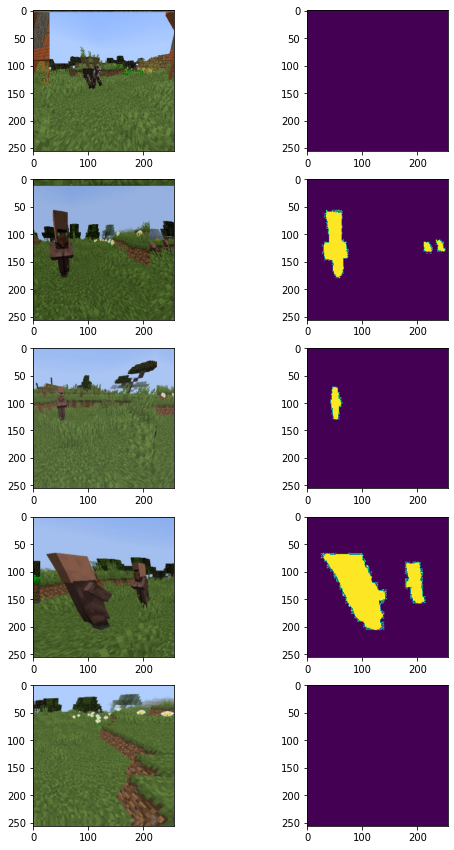

In [64]:
batch  = next(iter(train_loader))

images, masks = batch
fig, ax = plt.subplots(len(images), 2, figsize = (9,15))

for i in range(len(images)):

    image_color = np.moveaxis(images[i].numpy(),0,2)

    ax[i][0].imshow(image_color)
    ax[i][1].imshow(masks[i][0])

In [65]:
## workaround to fix model download 
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

In [66]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ["villager"]
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'
in_channels = 3

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
    in_channels = in_channels 
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [67]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00015),
])

scheduler = ReduceLROnPlateau(optimizer, 
                                mode='min', 
                                factor=0.7, 
                                patience=15, 
                                verbose=False, 
                                threshold=0.0001, 
                                threshold_mode='rel', 
                                cooldown=0, 
                                min_lr=0, 
                                eps=1e-08)

In [68]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=False,
)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [69]:
max_score = 0
dice_losses = []
iou_scores  = []
times = []
lrs = []

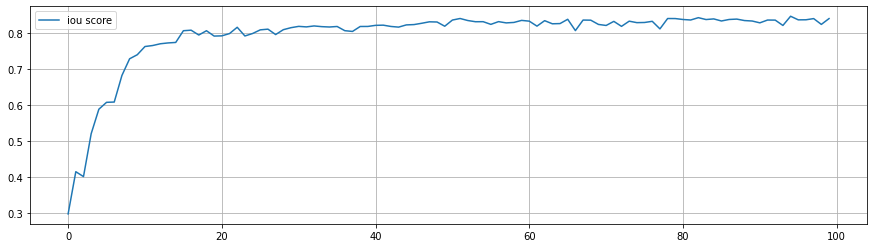

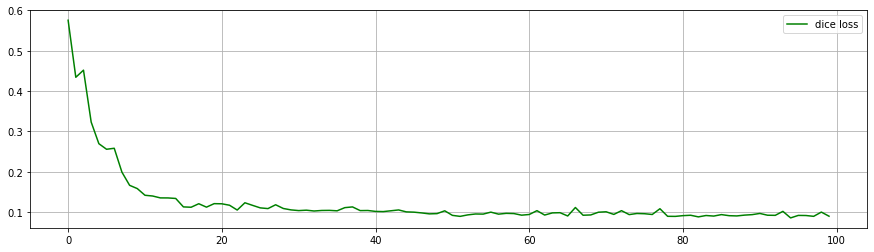

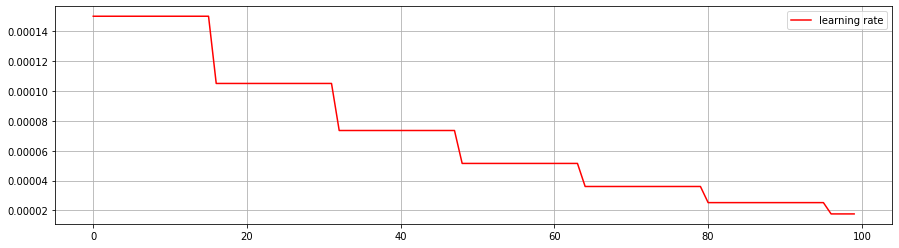

In [71]:
epochs = 50
plt.rcParams['figure.figsize'] = 15, 4
start_time = time.process_time()

for i in range(0, epochs):

    print('\nEpoch: {}'.format(i))

    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(val_loader)

    dice_losses.append(train_logs["dice_loss"]) 
    times.append(time.process_time() - start_time)
    iou_scores.append(train_logs["iou_score"])

    scheduler.step(1.)
    lrs.append(get_lr(optimizer))

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    clear_output(wait = True)
    
    plt.plot(iou_scores, label = "iou score")
    plt.legend()
    plt.grid()
    plt.show()

    plt.plot(dice_losses, color = "green", label = "dice loss")
    plt.legend()
    plt.grid()
    plt.show()

    plt.plot(lrs, label = "learning rate", color = "red")
    plt.legend()
    plt.grid()
    plt.show()


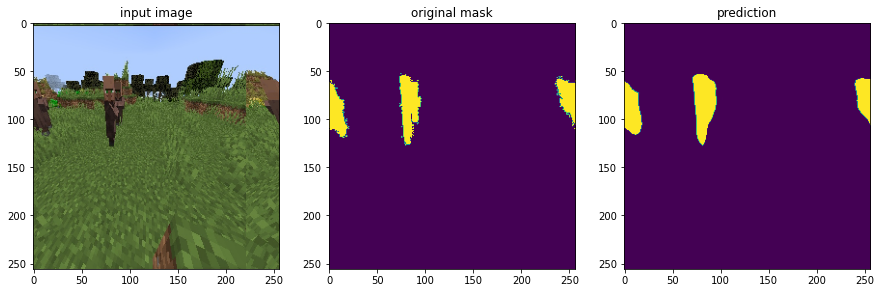

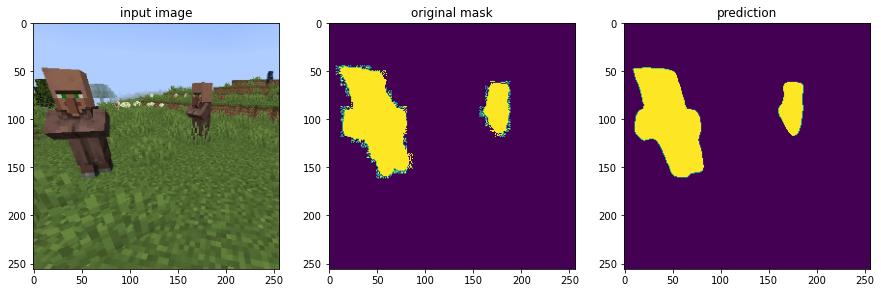

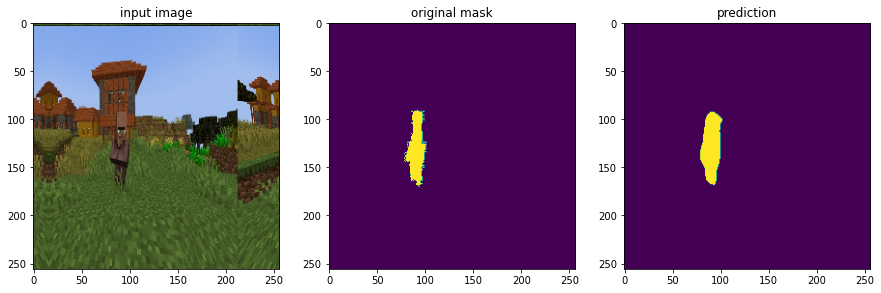

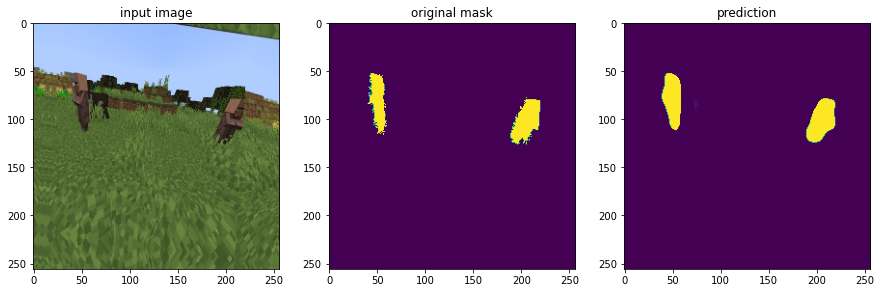

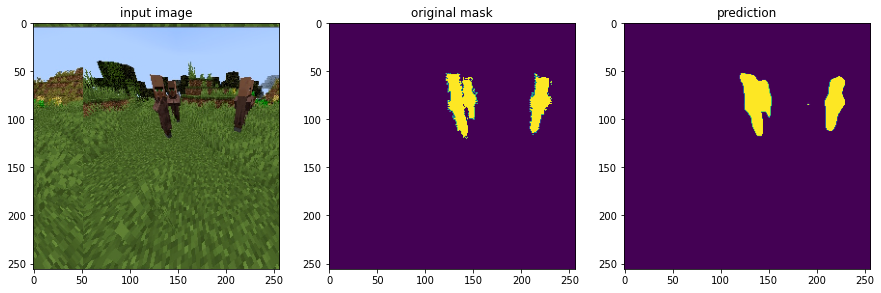

In [74]:
image, masks = next(iter(val_loader))

for i in range(len(image)):
    inp = image[i].cuda().unsqueeze(0)
    pred = model(inp).squeeze(0).squeeze(0).detach().cpu()
    show_img = np.moveaxis(inp.cpu()[0].numpy(),0,2)
    show_pred = model(inp).squeeze(0).squeeze(0).detach().cpu()
    show_pred[show_pred > 0.1] = 1
    show_mask = masks[i][0].cpu()
    fig, ax = plt.subplots(1,3, figsize = (15,35))

    ax.flat[0].imshow(show_img)
    ax.flat[0].title.set_text('input image')

    
    ax.flat[1].imshow(show_mask)
    ax.flat[1].title.set_text('original mask')

    ax.flat[2].imshow(show_pred)
    ax.flat[2].title.set_text('prediction')



In [75]:
!cp best_model.pth /content/drive/"My Drive"/minecraft_villagers/